In [40]:
from deeptools import heatmapper  # You need to have deeptools3 installed
import numpy as np
import gzip
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import seaborn as sns
sns.set_context('notebook')
sns.set_style('ticks')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['lines.markersize'] = 20
sns.set_context('talk')

from palettable.cartocolors.qualitative import Bold_10, Vivid_10_r, Antique_10_r
from matplotlib import markers

%matplotlib inline

### ASTARR

In [11]:
hm1 = heatmapper.heatmapper() # create heatmapper object
hm1.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/ASTARR_CommonBackgroundSet.promoters.mat.gz')

hm1.__dict__['parameters']['group_boundaries']


[0, 555, 1583]

In [12]:
hm2 = heatmapper.heatmapper() # create heatmapper object
hm2.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/ASTARR_CommonBackgroundSet.rest.mat.gz')

hm2.__dict__['parameters']['group_boundaries']

[0, 2282, 6256]

### AUC vs mean_signal in bubble plots

/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/numpy/lib/shape_base.py:652: UserWarning: Warning: converting a masked element to nan.
  arr = array(v, copy=False, subok=True)


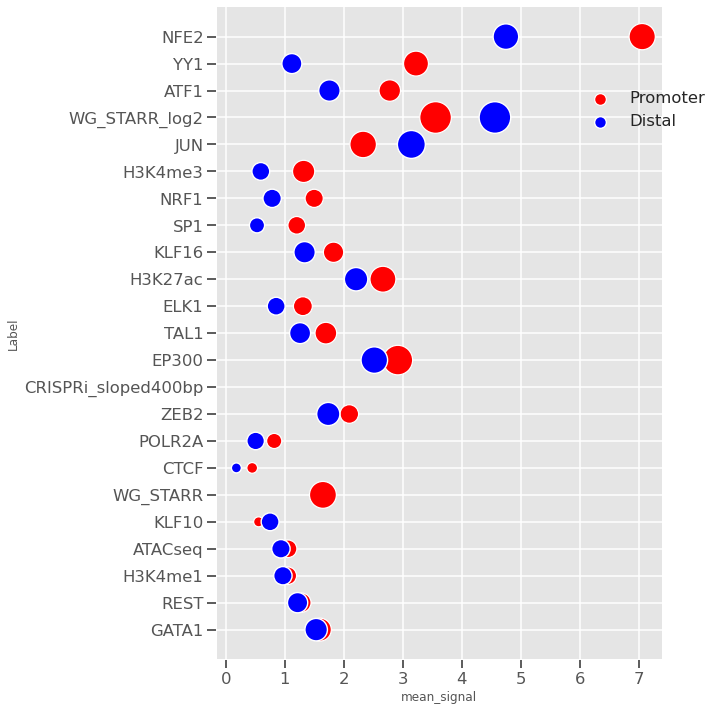

In [76]:
import pandas as pd
from numpy import trapz
from scipy.integrate import simpson
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=[8,12])

area_trap_promoter=[]
avg_signal_promoter=[]

area_trap_distal=[]
avg_signal_distal=[]

label=[]

for ii in range(len(hm1.__dict__['parameters']['sample_labels'])):
    if hm1.__dict__['parameters']['sample_labels'][ii] == 'ASTARR_log2': continue
        
    max_val_promoter=np.max(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_promoter=np.percentile(max_val_promoter,10)
    logFC_promoter=np.log2((np.nanmean(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0))/
                       (np.nanmean(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0)))
    area_trap_promoter.append(trapz(logFC_promoter, dx=10))
    avg_signal_promoter.append((np.nanmean(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150]))/(np.nanmean(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150])))
    
    
    max_val_distal=np.max(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_distal=np.percentile(max_val_distal,10)    
    logFC_distal=np.log2((np.nanmean(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0))/
                       (np.nanmean(hm2.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0)))
    area_trap_distal.append(trapz(logFC_distal, dx=10))
    avg_signal_distal.append((np.nanmean(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150]))/(np.nanmean(hm2.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150])))
    
    label.append(hm1.__dict__['parameters']['sample_labels'][ii])


DF_promoter = pd.DataFrame(np.column_stack([label, area_trap_promoter, avg_signal_promoter]), columns=['Label', 'AUC', 'mean_signal'])
DF_distal = pd.DataFrame(np.column_stack([label, area_trap_distal, avg_signal_distal]), columns=['Label', 'AUC', 'mean_signal'])

DF_promoter[['AUC','mean_signal']]=DF_promoter[['AUC','mean_signal']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_distal[['AUC','mean_signal']]=DF_distal[['AUC','mean_signal']].apply(pd.to_numeric, errors='coerce', axis=1)

DF_diff = pd.DataFrame(np.column_stack([DF_promoter['Label'],np.abs(DF_promoter['mean_signal']-DF_distal['mean_signal'])]), columns=['Label','Diff'])
DF_diff.sort_values(by='Diff', ascending=False, inplace=True)
DF_promoter=DF_promoter.set_index('Label')
DF_promoter=DF_promoter.reindex(index=DF_diff['Label'])
DF_promoter=DF_promoter.reset_index()

DF_distal=DF_distal.set_index('Label')
DF_distal=DF_distal.reindex(index=DF_diff['Label'])
DF_distal=DF_distal.reset_index()

sns.scatterplot(data=DF_promoter, x="mean_signal", y="Label", size="AUC", color='Red', legend=False, sizes=(100,1000))
sns.scatterplot(data=DF_distal, x="mean_signal", y="Label", size="AUC", color='Blue', legend=False, sizes=(100,1000))
fig.legend(labels=['Promoter','Distal'], bbox_to_anchor=(1,0.8), frameon=False, markerscale=0.5)


sns.despine()
plt.show()


### ChIPseq signal v/s mean signal in Bubble plots

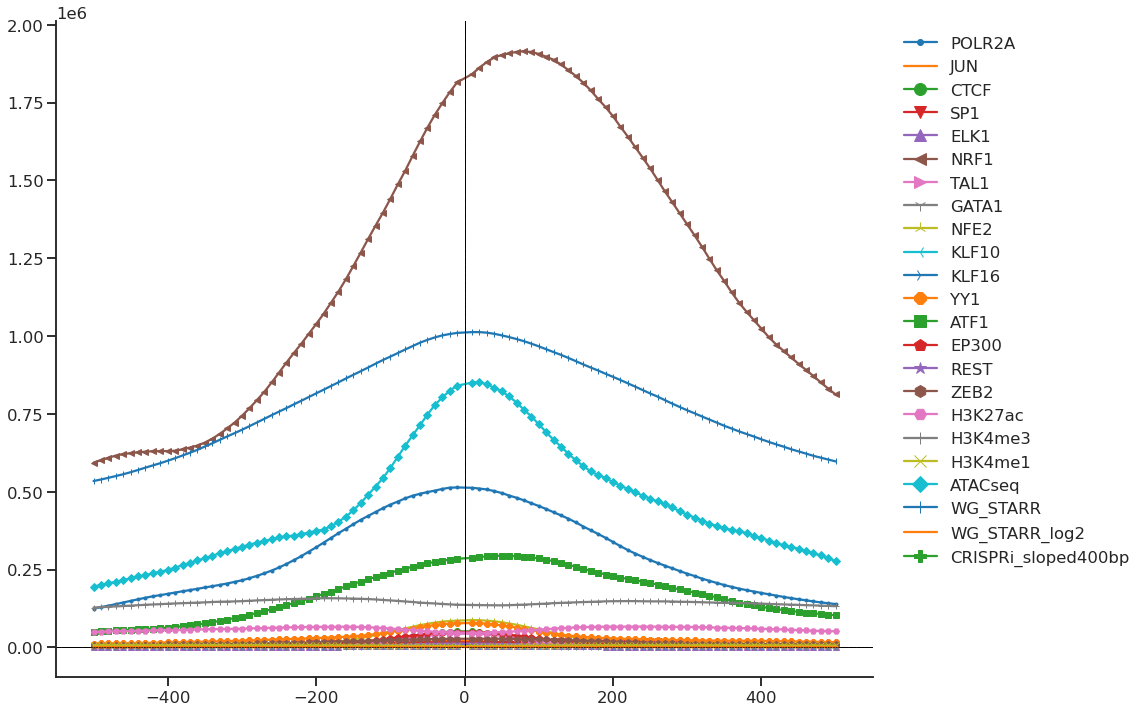

In [8]:
fig, ax = plt.subplots(figsize=[16,10])
for ii in range(len(hm1.__dict__['parameters']['sample_labels'])):
    if hm1.__dict__['parameters']['sample_labels'][ii] == 'ASTARR_log2': continue
        
    plt.plot(np.delete((np.arange(0,101)-50), 50)*10,
        np.sum(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150], axis=0)+np.sum(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150], axis=0),
        marker=list(markers.MarkerStyle().markers.keys())[ii],markersize=6,
        label=hm1.__dict__['parameters']['sample_labels'][ii])
    plt.axvline(0, color='black', ls='--', lw=.5)
    plt.axhline(0, color='black', ls='--', lw=.5)
    
lgnd = plt.legend(bbox_to_anchor=(1.02, 1), frameon=False, markerscale=2)
sns.despine()
plt.tight_layout()


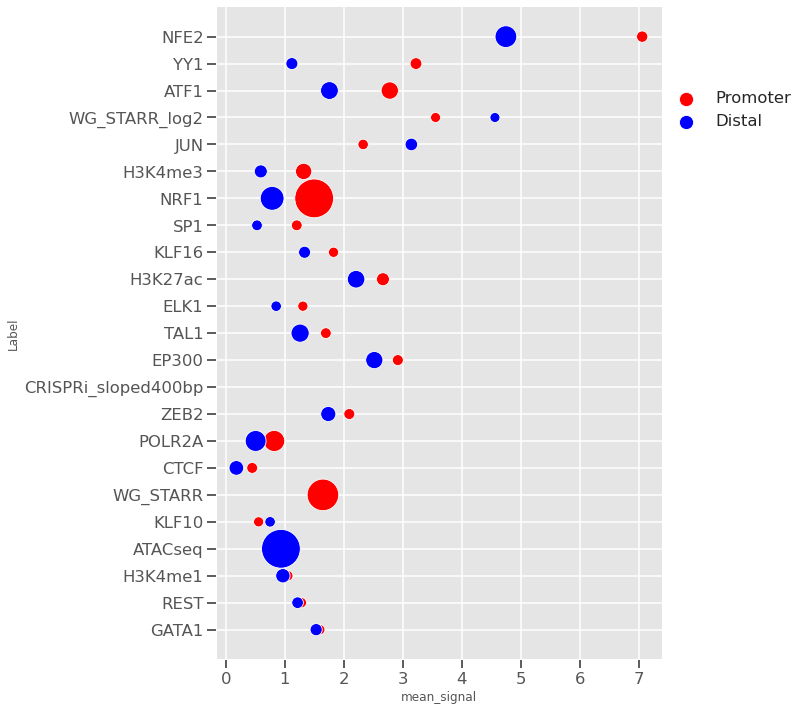

In [21]:
import pandas as pd
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=[8,12])

ChIP_signal_promoter=[]
avg_signal_promoter=[]

ChIP_signal_distal=[]
avg_signal_distal=[]

label=[]

for ii in range(len(hm1.__dict__['parameters']['sample_labels'])):
    if hm1.__dict__['parameters']['sample_labels'][ii] == 'ASTARR_log2': continue
        
    signal_promoter=np.sum(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150])+np.sum(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_signal_promoter.append(signal_promoter)
    avg_signal_promoter.append((np.nanmean(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150]))/(np.nanmean(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150])))
    
    signal_distal=np.sum(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150])+np.sum(hm2.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_signal_distal.append(signal_distal)
    avg_signal_distal.append((np.nanmean(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150]))/(np.nanmean(hm2.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150])))
    
    label.append(hm1.__dict__['parameters']['sample_labels'][ii])


DF_promoter = pd.DataFrame(np.column_stack([label, ChIP_signal_promoter, avg_signal_promoter]), columns=['Label', 'ChIP_signal', 'mean_signal'])
DF_distal = pd.DataFrame(np.column_stack([label, ChIP_signal_distal, avg_signal_distal]), columns=['Label', 'ChIP_signal', 'mean_signal'])

DF_promoter[['ChIP_signal','mean_signal']]=DF_promoter[['ChIP_signal','mean_signal']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_distal[['ChIP_signal','mean_signal']]=DF_distal[['ChIP_signal','mean_signal']].apply(pd.to_numeric, errors='coerce', axis=1)

DF_diff = pd.DataFrame(np.column_stack([DF_promoter['Label'],np.abs(DF_promoter['mean_signal']-DF_distal['mean_signal'])]), columns=['Label','Diff'])
DF_diff.sort_values(by='Diff', ascending=False, inplace=True)
DF_promoter=DF_promoter.set_index('Label')
DF_promoter=DF_promoter.reindex(index=DF_diff['Label'])
DF_promoter=DF_promoter.reset_index()

DF_distal=DF_distal.set_index('Label')
DF_distal=DF_distal.reindex(index=DF_diff['Label'])
DF_distal=DF_distal.reset_index()

sns.scatterplot(data=DF_promoter, x="mean_signal", y="Label", size="ChIP_signal", color='Red', legend=False, sizes=(100,1500))
sns.scatterplot(data=DF_distal, x="mean_signal", y="Label", size="ChIP_signal", color='Blue', legend=False, sizes=(100,1500))
fig.legend(labels=['Promoter','Distal'], bbox_to_anchor=(1.15,0.8), frameon=False, markerscale=0.5)


sns.despine()
plt.show()


### ChIP_signal_vs_AUC 

/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/numpy/lib/shape_base.py:652: UserWarning: Warning: converting a masked element to nan.
  arr = array(v, copy=False, subok=True)


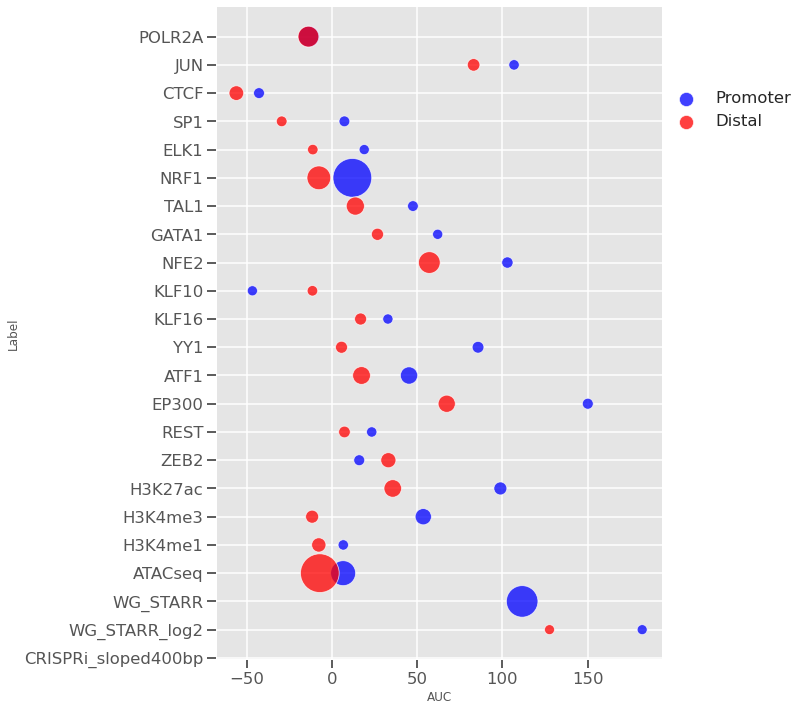

In [7]:
import pandas as pd
from numpy import trapz
from scipy.integrate import simpson
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=[8,12])

ChIP_signal_promoter=[]
area_trap_promoter=[]

ChIP_signal_distal=[]
area_trap_distal=[]

label=[]

for ii in range(len(hm1.__dict__['parameters']['sample_labels'])):
    if hm1.__dict__['parameters']['sample_labels'][ii] == 'ASTARR_log2': continue
    
    max_val_promoter=np.max(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_promoter=np.percentile(max_val_promoter,10)
    logFC_promoter=np.log2((np.nanmean(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0))/
                       (np.nanmean(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0)))
    area_trap_promoter.append(trapz(logFC_promoter, dx=10))
    signal_promoter=np.sum(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150])+np.sum(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_signal_promoter.append(signal_promoter)

    max_val_distal=np.max(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_distal=np.percentile(max_val_distal,10)    
    logFC_distal=np.log2((np.nanmean(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0))/
                       (np.nanmean(hm2.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0)))
    area_trap_distal.append(trapz(logFC_distal, dx=10))
    signal_distal=np.sum(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150])+np.sum(hm2.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_signal_distal.append(signal_distal)
    
    
    label.append(hm1.__dict__['parameters']['sample_labels'][ii])


DF_promoter = pd.DataFrame(np.column_stack([label, ChIP_signal_promoter, area_trap_promoter]), columns=['Label', 'ChIP_signal', 'AUC'])
DF_distal = pd.DataFrame(np.column_stack([label, ChIP_signal_distal, area_trap_distal]), columns=['Label', 'ChIP_signal', 'AUC'])

DF_promoter[['ChIP_signal','AUC']]=DF_promoter[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_distal[['ChIP_signal','AUC']]=DF_distal[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)

# DF_diff = pd.DataFrame(np.column_stack([DF_promoter['Label'],np.abs(DF_promoter['AUC']-DF_distal['AUC'])]), columns=['Label','Diff'])
# DF_diff.sort_values(by='Diff', ascending=False, inplace=True)
# DF_promoter=DF_promoter.set_index('Label')
# DF_promoter=DF_promoter.reindex(index=DF_diff['Label'])
# DF_promoter=DF_promoter.reset_index()

# DF_distal=DF_distal.set_index('Label')
# DF_distal=DF_distal.reindex(index=DF_diff['Label'])
# DF_distal=DF_distal.reset_index()

sns.scatterplot(data=DF_promoter, x="AUC", y="Label", size="ChIP_signal", color='Blue', legend=False, sizes=(100,1500), alpha=0.75)
sns.scatterplot(data=DF_distal, x="AUC", y="Label", size="ChIP_signal", color='Red', legend=False, sizes=(100,1500), alpha=0.75)
fig.legend(labels=['Promoter','Distal'], bbox_to_anchor=(1.15,0.8), frameon=False, markerscale=0.5)


sns.despine()
plt.show()


In [64]:
!mkdir -p /data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/bubble_plots

/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/numpy/lib/shape_base.py:652: UserWarning: Warning: converting a masked element to nan.
  arr = array(v, copy=False, subok=True)


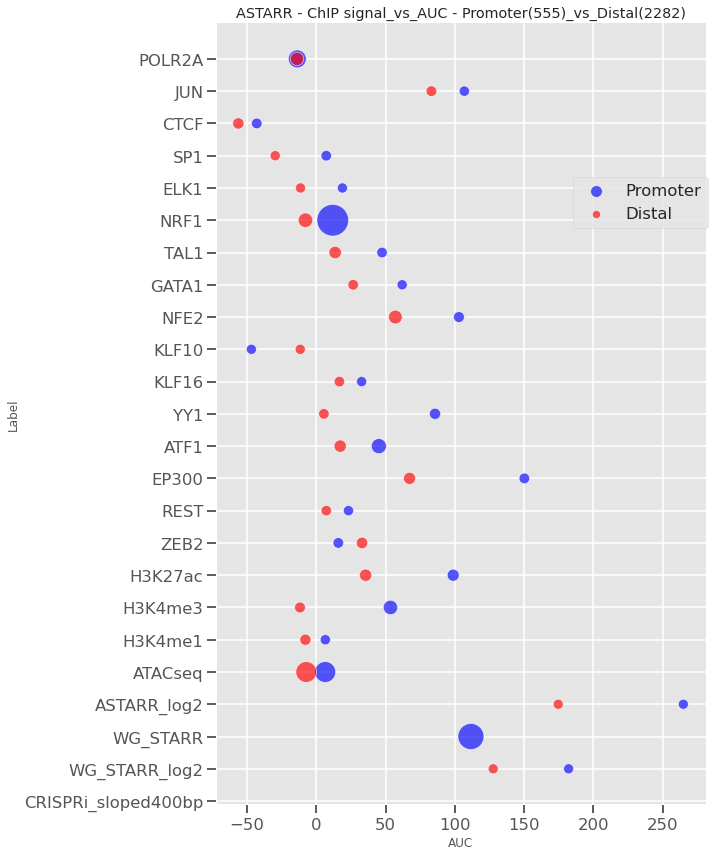

In [33]:
import pandas as pd
from numpy import trapz
from scipy.integrate import simpson
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=[10,12])

ChIP_signal_promoter=[]
area_trap_promoter=[]

ChIP_signal_distal=[]
area_trap_distal=[]

label=[]

for ii in range(len(hm1.__dict__['parameters']['sample_labels'])):
#     if hm1.__dict__['parameters']['sample_labels'][ii] == 'ASTARR_log2': continue
    
    max_val_promoter=np.max(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_promoter=np.percentile(max_val_promoter,10)
    logFC_promoter=np.log2((np.nanmean(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0))/
                       (np.nanmean(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0)))
    area_trap_promoter.append(trapz(logFC_promoter, dx=10))
    signal_promoter=(np.nansum(hm1.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm1.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150]))
    ChIP_signal_promoter.append(signal_promoter)

    max_val_distal=np.max(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_distal=np.percentile(max_val_distal,10)    
    logFC_distal=np.log2((np.nanmean(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0))/
                       (np.nanmean(hm2.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0)))
    area_trap_distal.append(trapz(logFC_distal, dx=10))
    signal_distal=(np.nansum(hm2.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm2.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150]))
    ChIP_signal_distal.append(signal_distal)
    
    
    label.append(hm1.__dict__['parameters']['sample_labels'][ii])


DF_promoter = pd.DataFrame(np.column_stack([label, ChIP_signal_promoter, area_trap_promoter]), columns=['Label', 'ChIP_signal', 'AUC'])
DF_distal = pd.DataFrame(np.column_stack([label, ChIP_signal_distal, area_trap_distal]), columns=['Label', 'ChIP_signal', 'AUC'])

DF_promoter[['ChIP_signal','AUC']]=DF_promoter[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_distal[['ChIP_signal','AUC']]=DF_distal[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)

# DF_diff = pd.DataFrame(np.column_stack([DF_promoter['Label'],np.abs(DF_promoter['ChIP_signal']-DF_distal['ChIP_signal'])]), columns=['Label','Diff'])
# DF_diff.sort_values(by='Diff', ascending=False, inplace=True)
# DF_promoter=DF_promoter.set_index('Label')
# DF_promoter=DF_promoter.reindex(index=DF_diff['Label'])
# DF_promoter=DF_promoter.reset_index()

# DF_distal=DF_distal.set_index('Label')
# DF_distal=DF_distal.reindex(index=DF_diff['Label'])
# DF_distal=DF_distal.reset_index()

sns.scatterplot(data=DF_promoter, x="AUC", y="Label", size="ChIP_signal", color='Blue', legend=False, sizes=(100,1000), alpha=0.65)
sns.scatterplot(data=DF_distal, x="AUC", y="Label", size="ChIP_signal", color='Red', legend=False, sizes=(100,1000), alpha=0.65)
fig.legend(labels=['Promoter','Distal'], bbox_to_anchor=(1,0.8), frameon=True, markerscale=0.5)
plt.title("ASTARR - ChIP signal_vs_AUC - Promoter(555)_vs_Distal(2282)")
sns.despine()
plt.tight_layout()
plt.savefig('data/enhancer_call_comparison/bubble_plots/ASTARR.ChIP_signal_vs_AUC.Promoter_vs_Distal.Bubbleplots.pdf')
plt.show()



### wgSTARR

In [15]:
hm3 = heatmapper.heatmapper() # create heatmapper object
hm3.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/wgSTARR_CommonBackgroundSet.promoters.mat.gz')

hm3.__dict__['parameters']['group_boundaries']


[0, 1684, 2541]

In [16]:
hm4 = heatmapper.heatmapper() # create heatmapper object
hm4.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/wgSTARR_CommonBackgroundSet.rest.mat.gz')

hm4.__dict__['parameters']['group_boundaries']

[0, 3316, 6602]

/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/numpy/lib/shape_base.py:652: UserWarning: Warning: converting a masked element to nan.
  arr = array(v, copy=False, subok=True)


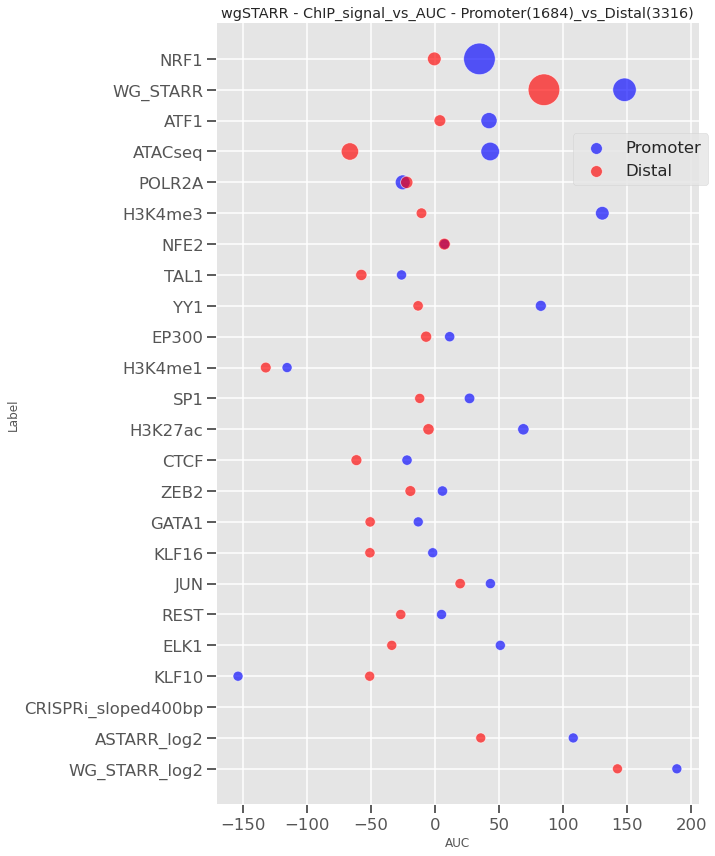

In [32]:
import pandas as pd
from numpy import trapz
from scipy.integrate import simpson
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=[10,12])

ChIP_signal_promoter=[]
area_trap_promoter=[]

ChIP_signal_distal=[]
area_trap_distal=[]

label=[]

for ii in range(len(hm3.__dict__['parameters']['sample_labels'])):
#     if hm1.__dict__['parameters']['sample_labels'][ii] == 'ASTARR_log2': continue
    
    max_val_promoter=np.max(hm3.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_promoter=np.percentile(max_val_promoter,10)
    logFC_promoter=np.log2((np.nanmean(hm3.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0))/
                       (np.nanmean(hm3.matrix.matrix[1684:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0)))
    area_trap_promoter.append(trapz(logFC_promoter, dx=10))
    signal_promoter=(np.nansum(hm3.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm3.matrix.matrix[1684:, ((ii)*400)+150:((ii+1)*400)-150]))
    ChIP_signal_promoter.append(signal_promoter)

    max_val_distal=np.max(hm4.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_distal=np.percentile(max_val_distal,10)    
    logFC_distal=np.log2((np.nanmean(hm4.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0))/
                       (np.nanmean(hm4.matrix.matrix[3316:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0)))
    area_trap_distal.append(trapz(logFC_distal, dx=10))
    signal_distal=(np.nansum(hm4.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm4.matrix.matrix[3316:, ((ii)*400)+150:((ii+1)*400)-150]))
    ChIP_signal_distal.append(signal_distal)
    
    
    label.append(hm3.__dict__['parameters']['sample_labels'][ii])


DF_promoter = pd.DataFrame(np.column_stack([label, ChIP_signal_promoter, area_trap_promoter]), columns=['Label', 'ChIP_signal', 'AUC'])
DF_distal = pd.DataFrame(np.column_stack([label, ChIP_signal_distal, area_trap_distal]), columns=['Label', 'ChIP_signal', 'AUC'])

DF_promoter[['ChIP_signal','AUC']]=DF_promoter[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_distal[['ChIP_signal','AUC']]=DF_distal[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)

DF_diff = pd.DataFrame(np.column_stack([DF_promoter['Label'],np.abs(DF_promoter['ChIP_signal']-DF_distal['ChIP_signal'])]), columns=['Label','Diff'])
DF_diff.sort_values(by='Diff', ascending=False, inplace=True)
DF_promoter=DF_promoter.set_index('Label')
DF_promoter=DF_promoter.reindex(index=DF_diff['Label'])
DF_promoter=DF_promoter.reset_index()

DF_distal=DF_distal.set_index('Label')
DF_distal=DF_distal.reindex(index=DF_diff['Label'])
DF_distal=DF_distal.reset_index()

sns.scatterplot(data=DF_promoter, x="AUC", y="Label", size="ChIP_signal", color='Blue', legend=False, sizes=(100,1000), alpha=0.65)
sns.scatterplot(data=DF_distal, x="AUC", y="Label", size="ChIP_signal", color='Red', legend=False, sizes=(100,1000), alpha=0.65)
fig.legend(labels=['Promoter','Distal'], bbox_to_anchor=(1,0.85), frameon=True, markerscale=0.5)
plt.title("wgSTARR - ChIP_signal_vs_AUC - Promoter(1684)_vs_Distal(3316)")
sns.despine()
plt.tight_layout()
plt.savefig('data/enhancer_call_comparison/bubble_plots/wgSTARR.ChIPsignal_vs_AUC.Promoter_vs_Distal.Bubbleplots.pdf')
plt.show()



#### LentiMPRA

In [22]:
hm5=heatmapper.heatmapper()
hm5.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/lentiMPRA_CommonBackgroundSet.promoters.mat.gz')
hm5.__dict__['parameters']['group_boundaries']


[0, 1587, 2526]

In [23]:
hm6=heatmapper.heatmapper()
hm6.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/lentiMPRA_CommonBackgroundSet.rest.mat.gz')
hm6.__dict__['parameters']['group_boundaries']

[0, 3408, 7473]

/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/data/reddylab/software/miniconda3/envs/alex_py3/lib/python3.7/site-packages/numpy/lib/shape_base.py:652: UserWarning: Warning: converting a masked element to nan.
  arr = array(v, copy=False, subok=True)


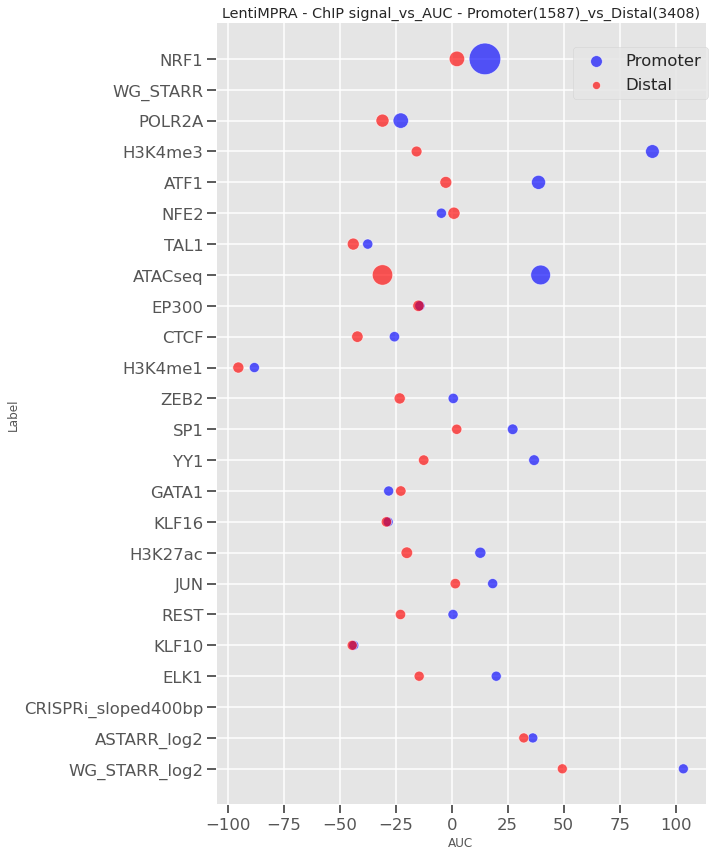

In [30]:
import pandas as pd
from numpy import trapz
from scipy.integrate import simpson
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=[10,12])

ChIP_signal_promoter=[]
area_trap_promoter=[]

ChIP_signal_distal=[]
area_trap_distal=[]

label=[]

for ii in range(len(hm3.__dict__['parameters']['sample_labels'])):
#     if hm1.__dict__['parameters']['sample_labels'][ii] == 'ASTARR_log2': continue
    
    max_val_promoter=np.max(hm5.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_promoter=np.percentile(max_val_promoter,10)
    logFC_promoter=np.log2((np.nanmean(hm5.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0))/
                       (np.nanmean(hm5.matrix.matrix[1587:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_promoter, axis=0)))
    area_trap_promoter.append(trapz(logFC_promoter, dx=10))
    signal_promoter=(np.nansum(hm5.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm5.matrix.matrix[1587:, ((ii)*400)+150:((ii+1)*400)-150]))
    ChIP_signal_promoter.append(signal_promoter)

    max_val_distal=np.max(hm6.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_distal=np.percentile(max_val_distal,10)    
    logFC_distal=np.log2((np.nanmean(hm6.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0))/
                       (np.nanmean(hm6.matrix.matrix[3408:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_distal, axis=0)))
    area_trap_distal.append(trapz(logFC_distal, dx=10))
    signal_distal=(np.nansum(hm6.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm6.matrix.matrix[3408:, ((ii)*400)+150:((ii+1)*400)-150]))
    ChIP_signal_distal.append(signal_distal)
    
    
    label.append(hm6.__dict__['parameters']['sample_labels'][ii])


DF_promoter = pd.DataFrame(np.column_stack([label, ChIP_signal_promoter, area_trap_promoter]), columns=['Label', 'ChIP_signal', 'AUC'])
DF_distal = pd.DataFrame(np.column_stack([label, ChIP_signal_distal, area_trap_distal]), columns=['Label', 'ChIP_signal', 'AUC'])

DF_promoter[['ChIP_signal','AUC']]=DF_promoter[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_distal[['ChIP_signal','AUC']]=DF_distal[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)

DF_diff = pd.DataFrame(np.column_stack([DF_promoter['Label'],np.abs(DF_promoter['ChIP_signal']-DF_distal['ChIP_signal'])]), columns=['Label','Diff'])
DF_diff.sort_values(by='Diff', ascending=False, inplace=True)
DF_promoter=DF_promoter.set_index('Label')
DF_promoter=DF_promoter.reindex(index=DF_diff['Label'])
DF_promoter=DF_promoter.reset_index()

DF_distal=DF_distal.set_index('Label')
DF_distal=DF_distal.reindex(index=DF_diff['Label'])
DF_distal=DF_distal.reset_index()

sns.scatterplot(data=DF_promoter, x="AUC", y="Label", size="ChIP_signal", color='Blue', legend=False, sizes=(100,1000), alpha=0.65)
sns.scatterplot(data=DF_distal, x="AUC", y="Label", size="ChIP_signal", color='Red', legend=False, sizes=(100,1000), alpha=0.65)
fig.legend(labels=['Promoter','Distal'], bbox_to_anchor=(1,0.95), frameon=True, markerscale=0.5)
plt.title("LentiMPRA - ChIP signal_vs_AUC - Promoter(1587)_vs_Distal(3408)")
sns.despine()
plt.tight_layout()
plt.savefig('data/enhancer_call_comparison/bubble_plots/LentiMPRA.ChIPsignal_vs_AUC.Promoter_vs_Distal.Bubbleplots.pdf')
plt.show()


### Bubble plots for promoters

In [41]:
hm_ASTARRp=heatmapper.heatmapper()
hm_ASTARRp.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/ASTARR_CommonBackgroundSet.promoters.mat.gz')

hm_ASTARRd=heatmapper.heatmapper()
hm_ASTARRd.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/ASTARR_CommonBackgroundSet.rest.mat.gz')

hm_lentiMPRAp=heatmapper.heatmapper()
hm_lentiMPRAp.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/lentiMPRA_CommonBackgroundSet.promoters.mat.gz')

hm_lentiMPRAd=heatmapper.heatmapper()
hm_lentiMPRAd.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/lentiMPRA_CommonBackgroundSet.rest.mat.gz')

hm_wgSTARRp=heatmapper.heatmapper()
hm_wgSTARRp.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/wgSTARR_CommonBackgroundSet.promoters.mat.gz')

hm_wgSTARRd=heatmapper.heatmapper()
hm_wgSTARRd.read_matrix_file('/data/reddylab/Revathy/collabs/Jamborees/fcc_capstone/data/enhancer_call_comparison/10032022/wgSTARR_CommonBackgroundSet.rest.mat.gz')


In [6]:
label=hm_ASTARRp.__dict__['parameters']['sample_labels'][0:19]
print(label)

['POLR2A', 'JUN', 'CTCF', 'SP1', 'ELK1', 'NRF1', 'TAL1', 'GATA1', 'NFE2', 'KLF10', 'KLF16', 'YY1', 'ATF1', 'EP300', 'REST', 'ZEB2', 'H3K27ac', 'H3K4me3', 'H3K4me1']


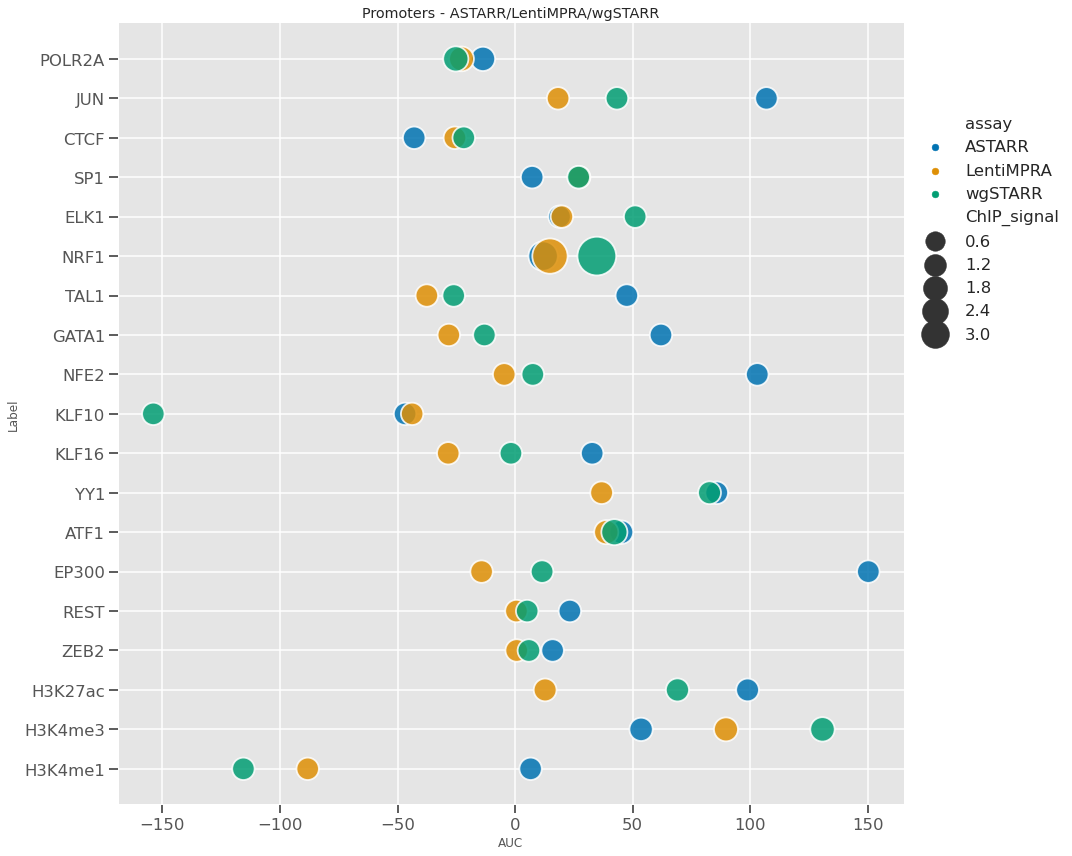

In [7]:
import pandas as pd
from numpy import trapz
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=[15,12])

ChIP_ASTARR=[]
ChIP_Lenti=[]
ChIP_wgSTARR=[]

AUC_ASTARR=[]
AUC_Lenti=[]
AUC_wgSTARR=[]

label=hm_ASTARRp.__dict__['parameters']['sample_labels'][0:19]

for ii in range(len(label)):
    
    max_val_ASTARR=np.max(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_ASTARR=np.percentile(max_val_ASTARR,10)
    logFC_ASTARR=np.log2((np.nanmean(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARR, axis=0))/
                       (np.nanmean(hm_ASTARRp.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARR, axis=0)))
    AUC_ASTARR.append(trapz(logFC_ASTARR, dx=10))
    signal_ASTARR=np.nansum(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_ASTARRp.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_ASTARR.append(signal_ASTARR)
    
    
    max_val_Lenti=np.max(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_Lenti=np.percentile(max_val_Lenti,10)
    logFC_Lenti=np.log2((np.nanmean(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lenti, axis=0))/
                       (np.nanmean(hm_lentiMPRAp.matrix.matrix[1587:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lenti, axis=0)))
    AUC_Lenti.append(trapz(logFC_Lenti, dx=10))
    signal_Lenti=np.nansum(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_lentiMPRAp.matrix.matrix[1587:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_Lenti.append(signal_Lenti)
    
    
    max_val_wgSTARR=np.max(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_wgSTARR=np.percentile(max_val_wgSTARR,10)
    logFC_wgSTARR=np.log2((np.nanmean(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARR, axis=0))/
                       (np.nanmean(hm_wgSTARRp.matrix.matrix[1684:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARR, axis=0)))
    AUC_wgSTARR.append(trapz(logFC_wgSTARR, dx=10))
    signal_wgSTARR=np.nansum(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_wgSTARRp.matrix.matrix[1684:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_wgSTARR.append(signal_wgSTARR)
    
DF_ASTARR = pd.DataFrame(np.column_stack([label, ChIP_ASTARR, AUC_ASTARR]), columns=['Label', 'ChIP_signal', 'AUC'])
DF_Lenti = pd.DataFrame(np.column_stack([label, ChIP_Lenti, AUC_Lenti]), columns=['Label', 'ChIP_signal', 'AUC'])
DF_wgSTARR = pd.DataFrame(np.column_stack([label, ChIP_wgSTARR, AUC_wgSTARR]), columns=['Label', 'ChIP_signal', 'AUC'])

DF_ASTARR[['ChIP_signal','AUC']]=DF_ASTARR[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_Lenti[['ChIP_signal','AUC']]=DF_Lenti[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1) 
DF_wgSTARR[['ChIP_signal','AUC']]=DF_wgSTARR[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)

DF_ASTARR['assay']='ASTARR'
DF_Lenti['assay']='LentiMPRA'
DF_wgSTARR['assay']='wgSTARR'

DF = pd.concat([DF_ASTARR, DF_Lenti, DF_wgSTARR], axis=0)

sns.scatterplot(data=DF, x="AUC", y="Label", size="ChIP_signal", hue='assay', legend=True, sizes=(500,1500), alpha=0.85, palette='colorblind')
# sns.scatterplot(data=DF_ASTARR, x="AUC", y="Label", size="ChIP_signal", color='Green', legend=False, sizes=(100,1500), alpha=0.65)
# sns.scatterplot(data=DF_Lenti, x="AUC", y="Label", size="ChIP_signal", color='Purple', legend=False, sizes=(100,1500), alpha=0.65)
# sns.scatterplot(data=DF_wgSTARR, x="AUC", y="Label", size="ChIP_signal", color='Orange', legend=False, sizes=(100,1500), alpha=0.65)

plt.legend(bbox_to_anchor=(1,0.9), frameon=False, markerscale=0.75, loc='upper left')
plt.title("Promoters - ASTARR/LentiMPRA/wgSTARR")
sns.despine()
plt.tight_layout()
plt.savefig('data/enhancer_call_comparison/bubble_plots/Promoter_ASTARR_Lenti_wgSTARR.ChIP_signal_vs_AUC.Bubbleplot.pdf')
plt.show()


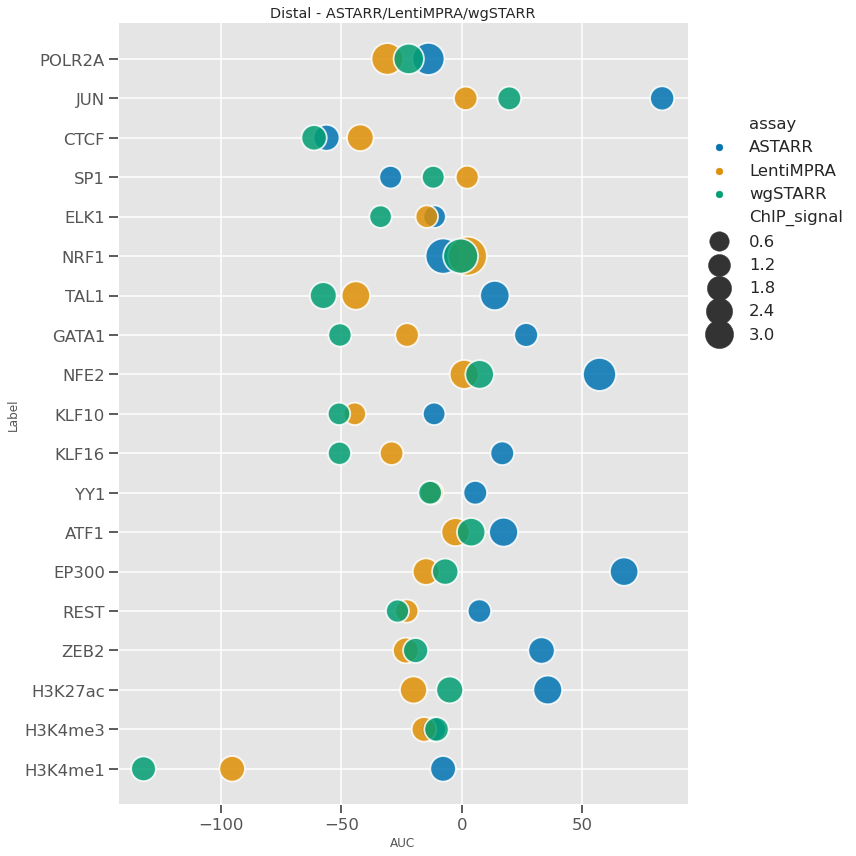

In [60]:
import pandas as pd
from numpy import trapz
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=[12,12])

ChIP_ASTARR=[]
ChIP_Lenti=[]
ChIP_wgSTARR=[]

AUC_ASTARR=[]
AUC_Lenti=[]
AUC_wgSTARR=[]

label=hm_ASTARRd.__dict__['parameters']['sample_labels'][0:19]

for ii in range(len(label)):
    
    max_val_ASTARR=np.max(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_ASTARR=np.percentile(max_val_ASTARR,10)
    logFC_ASTARR=np.log2((np.nanmean(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARR, axis=0))/
                       (np.nanmean(hm_ASTARRd.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARR, axis=0)))
    AUC_ASTARR.append(trapz(logFC_ASTARR, dx=10))
    signal_ASTARR=np.nansum(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_ASTARRd.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_ASTARR.append(signal_ASTARR)
    
    
    max_val_Lenti=np.max(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_Lenti=np.percentile(max_val_Lenti,10)
    logFC_Lenti=np.log2((np.nanmean(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lenti, axis=0))/
                       (np.nanmean(hm_lentiMPRAd.matrix.matrix[3408:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lenti, axis=0)))
    AUC_Lenti.append(trapz(logFC_Lenti, dx=10))
    signal_Lenti=np.nansum(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_lentiMPRAd.matrix.matrix[3408:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_Lenti.append(signal_Lenti)
    
    
    max_val_wgSTARR=np.max(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_wgSTARR=np.percentile(max_val_wgSTARR,10)
    logFC_wgSTARR=np.log2((np.nanmean(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARR, axis=0))/
                       (np.nanmean(hm_wgSTARRd.matrix.matrix[3316:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARR, axis=0)))
    AUC_wgSTARR.append(trapz(logFC_wgSTARR, dx=10))
    signal_wgSTARR=np.nansum(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_wgSTARRd.matrix.matrix[3316:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_wgSTARR.append(signal_wgSTARR)
    
DF_ASTARR = pd.DataFrame(np.column_stack([label, ChIP_ASTARR, AUC_ASTARR]), columns=['Label', 'ChIP_signal', 'AUC'])
DF_Lenti = pd.DataFrame(np.column_stack([label, ChIP_Lenti, AUC_Lenti]), columns=['Label', 'ChIP_signal', 'AUC'])
DF_wgSTARR = pd.DataFrame(np.column_stack([label, ChIP_wgSTARR, AUC_wgSTARR]), columns=['Label', 'ChIP_signal', 'AUC'])

DF_ASTARR[['ChIP_signal','AUC']]=DF_ASTARR[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_Lenti[['ChIP_signal','AUC']]=DF_Lenti[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1) 
DF_wgSTARR[['ChIP_signal','AUC']]=DF_wgSTARR[['ChIP_signal','AUC']].apply(pd.to_numeric, errors='coerce', axis=1)

DF_ASTARR['assay']='ASTARR'
DF_Lenti['assay']='LentiMPRA'
DF_wgSTARR['assay']='wgSTARR'

DF = pd.concat([DF_ASTARR, DF_Lenti, DF_wgSTARR], axis=0)

sns.scatterplot(data=DF, x="AUC", y="Label", size="ChIP_signal", hue='assay', legend=True, sizes=(500,1500), alpha=0.85, palette='colorblind')
# sns.scatterplot(data=DF_ASTARR, x="AUC", y="Label", size="ChIP_signal", color='Green', legend=False, sizes=(100,1500), alpha=0.65)
# sns.scatterplot(data=DF_Lenti, x="AUC", y="Label", size="ChIP_signal", color='Purple', legend=False, sizes=(100,1500), alpha=0.65)
# sns.scatterplot(data=DF_wgSTARR, x="AUC", y="Label", size="ChIP_signal", color='Orange', legend=False, sizes=(100,1500), alpha=0.65)

plt.legend(bbox_to_anchor=(1,0.9), frameon=False, markerscale=0.75, loc='upper left')
plt.title("Distal - ASTARR/LentiMPRA/wgSTARR")
sns.despine()
plt.tight_layout()
plt.savefig('data/enhancer_call_comparison/bubble_plots/Distal_ASTARR_Lenti_wgSTARR.ChIP_signal_vs_AUC.Bubbleplot.pdf')
plt.show()


## Summary heatmaps

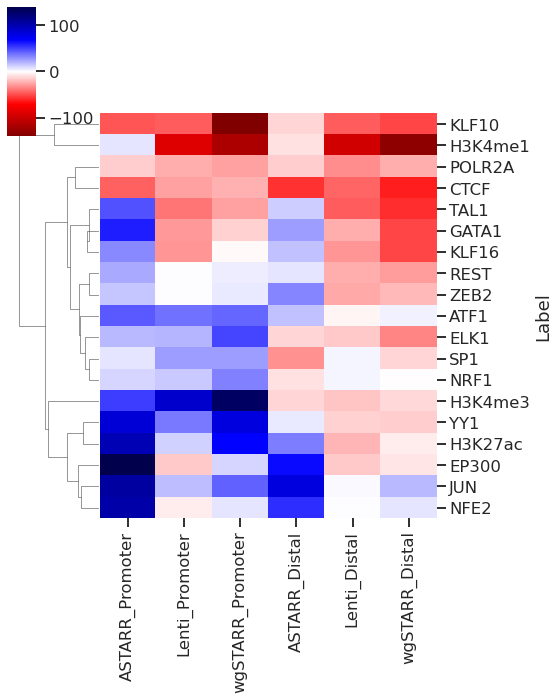

In [42]:
import pandas as pd
import numpy as np
from numpy import trapz
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# ChIP_ASTARR=[]
# ChIP_Lenti=[]
# ChIP_wgSTARR=[]

AUC_ASTARRp=[]
AUC_ASTARRd=[]
AUC_Lentip=[]
AUC_Lentid=[]
AUC_wgSTARRp=[]
AUC_wgSTARRd=[]

label=hm_ASTARRd.__dict__['parameters']['sample_labels'][0:19]

for ii in range(len(label)):
    
    max_val_ASTARRp=np.max(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_ASTARRp=np.percentile(max_val_ASTARRp,10)
    logFC_ASTARRp=np.log2((np.nanmean(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARRp, axis=0))/
                       (np.nanmean(hm_ASTARRp.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARRp, axis=0)))
    AUC_ASTARRp.append(trapz(logFC_ASTARRp, dx=10))

    max_val_Lentip=np.max(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_Lentip=np.percentile(max_val_Lentip,10)
    logFC_Lentip=np.log2((np.nanmean(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lentip, axis=0))/
                       (np.nanmean(hm_lentiMPRAp.matrix.matrix[1587:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lentip, axis=0)))
    AUC_Lentip.append(trapz(logFC_Lentip, dx=10))

    max_val_wgSTARRp=np.max(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_wgSTARRp=np.percentile(max_val_wgSTARRp,10)
    logFC_wgSTARRp=np.log2((np.nanmean(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARRp, axis=0))/
                       (np.nanmean(hm_wgSTARRp.matrix.matrix[1684:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARRp, axis=0)))
    AUC_wgSTARRp.append(trapz(logFC_wgSTARRp, dx=10))
    
    max_val_ASTARRd=np.max(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_ASTARRd=np.percentile(max_val_ASTARRd,10)
    logFC_ASTARRd=np.log2((np.nanmean(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARRd, axis=0))/
                       (np.nanmean(hm_ASTARRd.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARRd, axis=0)))
    AUC_ASTARRd.append(trapz(logFC_ASTARRd, dx=10))
        
    max_val_Lentid=np.max(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_Lentid=np.percentile(max_val_Lentid,10)
    logFC_Lentid=np.log2((np.nanmean(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lentid, axis=0))/
                       (np.nanmean(hm_lentiMPRAd.matrix.matrix[3408:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lentid, axis=0)))
    AUC_Lentid.append(trapz(logFC_Lentid, dx=10))
    
    max_val_wgSTARRd=np.max(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_wgSTARRd=np.percentile(max_val_wgSTARRd,10)
    logFC_wgSTARRd=np.log2((np.nanmean(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARRd, axis=0))/
                       (np.nanmean(hm_wgSTARRd.matrix.matrix[3316:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARRd, axis=0)))
    AUC_wgSTARRd.append(trapz(logFC_wgSTARRd, dx=10))

DF_ASTARR = pd.DataFrame(np.column_stack([label, AUC_ASTARRp, AUC_ASTARRd]), columns=['Label', 'ASTARR_Promoter', 'ASTARR_Distal'])
DF_Lenti = pd.DataFrame(np.column_stack([label, AUC_Lentip, AUC_Lentid]), columns=['Label', 'Lenti_Promoter', 'Lenti_Distal'])
DF_wgSTARR = pd.DataFrame(np.column_stack([label, AUC_wgSTARRp, AUC_wgSTARRd]), columns=['Label', 'wgSTARR_Promoter', 'wgSTARR_Distal'])

DF_ASTARR[['ASTARR_Promoter','ASTARR_Distal']]=DF_ASTARR[['ASTARR_Promoter','ASTARR_Distal']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_Lenti[['Lenti_Promoter','Lenti_Distal']]=DF_Lenti[['Lenti_Promoter','Lenti_Distal']].apply(pd.to_numeric, errors='coerce', axis=1) 
DF_wgSTARR[['wgSTARR_Promoter','wgSTARR_Distal']]=DF_wgSTARR[['wgSTARR_Promoter','wgSTARR_Distal']].apply(pd.to_numeric, errors='coerce', axis=1)

DF = DF_ASTARR.merge(DF_Lenti, on='Label', how='inner').merge(DF_wgSTARR, on='Label', how='inner')

DF = DF.set_index('Label')
DF = DF.fillna(0)
sns.clustermap(DF.loc[:, ['ASTARR_Promoter','Lenti_Promoter','wgSTARR_Promoter','ASTARR_Distal','Lenti_Distal','wgSTARR_Distal']],
               method='median',
               figsize=[8,10],
               vmin=-140,
               vmax=140,
               cmap='seismic_r',
               col_cluster= False, 
               cbar_pos=(0.02, 0.8, 0.05, 0.18))


plt.savefig('data/enhancer_call_comparison/bubble_plots/ASTARR_Lenti_wgSTARR.Promoter_Distal.AUC_summary_heatmaps.png')

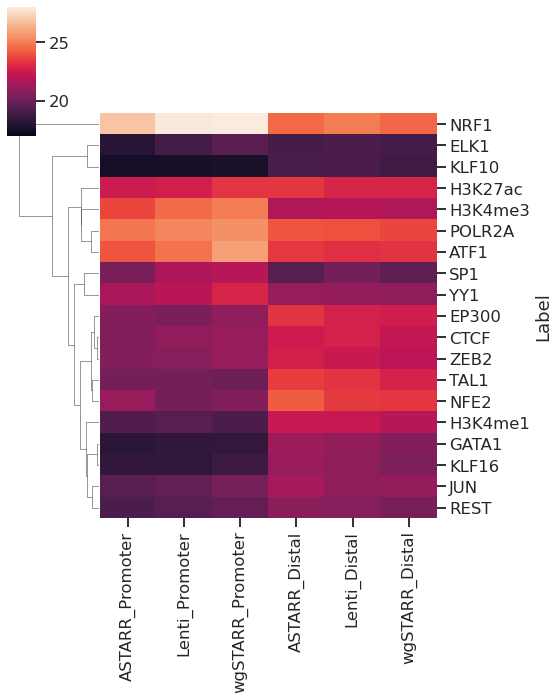

In [28]:
import pandas as pd
import numpy as np
from numpy import trapz
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

ChIP_ASTARRp=[]
ChIP_ASTARRd=[]
ChIP_Lentip=[]
ChIP_Lentid=[]
ChIP_wgSTARRp=[]
ChIP_wgSTARRd=[]

label=hm_ASTARRd.__dict__['parameters']['sample_labels'][0:19]

for ii in range(len(label)):
    
    signal_ASTARRp=np.nansum(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_ASTARRp.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_ASTARRp.append(signal_ASTARRp)
    
    signal_ASTARRd=np.nansum(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_ASTARRd.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_ASTARRd.append(signal_ASTARRd) 
    
    signal_Lentip=np.nansum(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_lentiMPRAp.matrix.matrix[1587:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_Lentip.append(signal_Lentip)
    
    signal_Lentid=np.nansum(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_lentiMPRAd.matrix.matrix[3408:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_Lentid.append(signal_Lentid)
    
    signal_wgSTARRp=np.nansum(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_wgSTARRp.matrix.matrix[1684:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_wgSTARRp.append(signal_wgSTARRp)
    
    signal_wgSTARRd=np.nansum(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_wgSTARRd.matrix.matrix[3316:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_wgSTARRd.append(signal_wgSTARRd)
    
DF_ASTARR = pd.DataFrame(np.column_stack([label, ChIP_ASTARRp, ChIP_ASTARRd]), columns=['Label', 'ASTARR_Promoter', 'ASTARR_Distal'])
DF_Lenti = pd.DataFrame(np.column_stack([label, ChIP_Lentip, ChIP_Lentid]), columns=['Label', 'Lenti_Promoter', 'Lenti_Distal'])
DF_wgSTARR = pd.DataFrame(np.column_stack([label, ChIP_wgSTARRp, ChIP_wgSTARRd]), columns=['Label', 'wgSTARR_Promoter', 'wgSTARR_Distal'])

DF_ASTARR[['ASTARR_Promoter','ASTARR_Distal']]=DF_ASTARR[['ASTARR_Promoter','ASTARR_Distal']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_Lenti[['Lenti_Promoter','Lenti_Distal']]=DF_Lenti[['Lenti_Promoter','Lenti_Distal']].apply(pd.to_numeric, errors='coerce', axis=1) 
DF_wgSTARR[['wgSTARR_Promoter','wgSTARR_Distal']]=DF_wgSTARR[['wgSTARR_Promoter','wgSTARR_Distal']].apply(pd.to_numeric, errors='coerce', axis=1)

DF = DF_ASTARR.merge(DF_Lenti, on='Label', how='inner').merge(DF_wgSTARR, on='Label', how='inner')

DF = DF.set_index('Label')
DF = DF.transform(lambda x: np.log2(x))
sns.clustermap(DF.loc[:, ['ASTARR_Promoter','Lenti_Promoter','wgSTARR_Promoter','ASTARR_Distal','Lenti_Distal','wgSTARR_Distal']],
               method='median',
               figsize=[8,10],
               vmin=17,
               vmax=28,
               col_cluster= False)


plt.savefig('data/enhancer_call_comparison/bubble_plots/ASTARR_Lenti_wgSTARR.Promoter_Distal.Total_ChIP_signal_summary_heatmaps.pdf')

In [37]:
DF.describe()

,ASTARR_Promoter,ASTARR_Distal,Lenti_Promoter,Lenti_Distal,wgSTARR_Promoter,wgSTARR_Distal
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,20.946878,22.088297,21.263300,21.980576,21.616665,21.708558
std,2.494627,1.684516,2.702778,1.575140,2.846892,1.597977
min,17.619626,19.057057,17.670493,19.200310,17.754443,18.882636
25%,19.236290,21.165425,19.533813,20.955668,19.704744,20.553861
50%,20.592332,22.398438,20.460641,22.387614,20.981912,21.958681
75%,22.077446,23.418824,22.362751,23.075825,23.104049,22.839190
max,26.873678,24.550983,27.923888,24.981759,28.348209,24.511514


## Split the heatmaps into promoter and distal
### Promoter with AUC

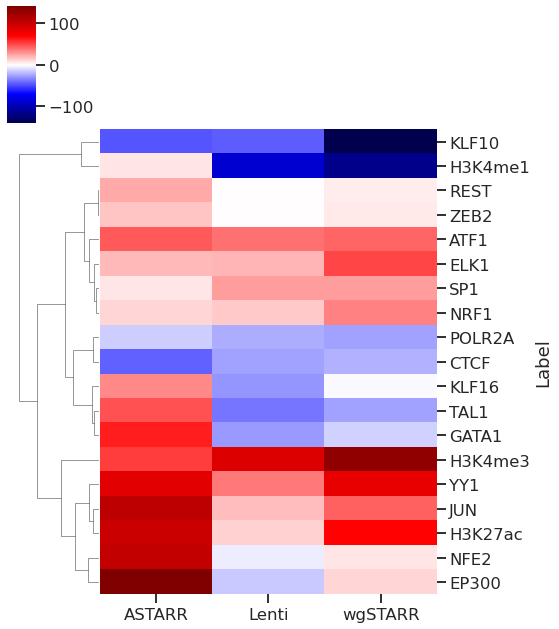

In [13]:
import pandas as pd
import numpy as np
from numpy import trapz
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

AUC_ASTARRp=[]
AUC_Lentip=[]
AUC_wgSTARRp=[]


label=hm_ASTARRd.__dict__['parameters']['sample_labels'][0:19]

for ii in range(len(label)):
    
    max_val_ASTARRp=np.max(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_ASTARRp=np.percentile(max_val_ASTARRp,10)
    logFC_ASTARRp=np.log2((np.nanmean(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARRp, axis=0))/
                       (np.nanmean(hm_ASTARRp.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARRp, axis=0)))
    AUC_ASTARRp.append(trapz(logFC_ASTARRp, dx=10))


    max_val_Lentip=np.max(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_Lentip=np.percentile(max_val_Lentip,10)
    logFC_Lentip=np.log2((np.nanmean(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lentip, axis=0))/
                       (np.nanmean(hm_lentiMPRAp.matrix.matrix[1587:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lentip, axis=0)))
    AUC_Lentip.append(trapz(logFC_Lentip, dx=10))

    max_val_wgSTARRp=np.max(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_wgSTARRp=np.percentile(max_val_wgSTARRp,10)
    logFC_wgSTARRp=np.log2((np.nanmean(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARRp, axis=0))/
                       (np.nanmean(hm_wgSTARRp.matrix.matrix[1684:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARRp, axis=0)))
    AUC_wgSTARRp.append(trapz(logFC_wgSTARRp, dx=10))

DF_ASTARR = pd.DataFrame(np.column_stack([label, AUC_ASTARRp]), columns=['Label', 'ASTARR'])
DF_Lenti = pd.DataFrame(np.column_stack([label, AUC_Lentip]), columns=['Label', 'Lenti'])
DF_wgSTARR = pd.DataFrame(np.column_stack([label, AUC_wgSTARRp]), columns=['Label', 'wgSTARR'])

DF_ASTARR[['ASTARR']]=DF_ASTARR[['ASTARR']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_Lenti[['Lenti']]=DF_Lenti[['Lenti']].apply(pd.to_numeric, errors='coerce', axis=1) 
DF_wgSTARR[['wgSTARR']]=DF_wgSTARR[['wgSTARR']].apply(pd.to_numeric, errors='coerce', axis=1)

DF = DF_ASTARR.merge(DF_Lenti, on='Label', how='inner').merge(DF_wgSTARR, on='Label', how='inner')

DF = DF.set_index('Label')
DF = DF.fillna(0)
sns.clustermap(DF.loc[:, ['ASTARR','Lenti','wgSTARR']],
               method='ward',
               figsize=[8,9],
               vmin=-140,
               vmax=140,
               cmap='seismic',
               col_cluster= False)



### Distal with AUC

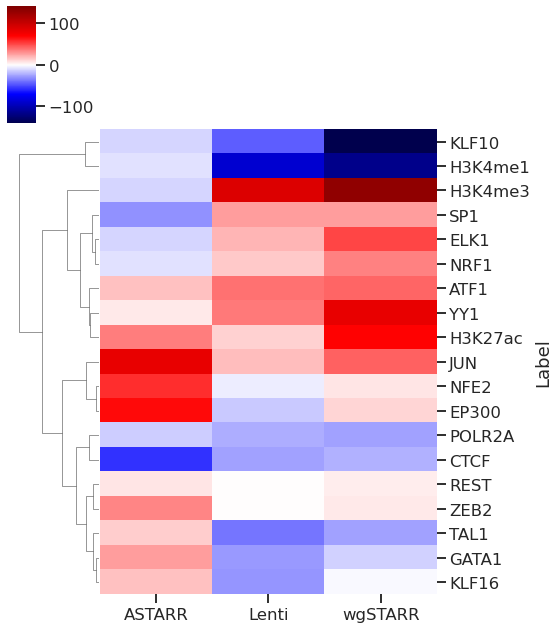

In [14]:
import pandas as pd
import numpy as np
from numpy import trapz
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})


AUC_ASTARRd=[]
AUC_Lentid=[]
AUC_wgSTARRd=[]

label=hm_ASTARRd.__dict__['parameters']['sample_labels'][0:19]

for ii in range(len(label)):
    

    max_val_ASTARRd=np.max(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_ASTARRd=np.percentile(max_val_ASTARRd,10)
    logFC_ASTARRd=np.log2((np.nanmean(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARRd, axis=0))/
                       (np.nanmean(hm_ASTARRd.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_ASTARRd, axis=0)))
    AUC_ASTARRd.append(trapz(logFC_ASTARRd, dx=10))
    
    max_val_Lentid=np.max(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_Lentid=np.percentile(max_val_Lentid,10)
    logFC_Lentid=np.log2((np.nanmean(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lentid, axis=0))/
                       (np.nanmean(hm_lentiMPRAd.matrix.matrix[3408:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_Lentid, axis=0)))
    AUC_Lentid.append(trapz(logFC_Lentid, dx=10))

    max_val_wgSTARRd=np.max(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150], axis=0)
    pseudo_count_wgSTARRd=np.percentile(max_val_wgSTARRd,10)
    logFC_wgSTARRd=np.log2((np.nanmean(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARRd, axis=0))/
                       (np.nanmean(hm_wgSTARRd.matrix.matrix[3316:, ((ii)*400)+150:((ii+1)*400)-150]+pseudo_count_wgSTARRd, axis=0)))
    AUC_wgSTARRd.append(trapz(logFC_wgSTARRd, dx=10))

DF_ASTARR = pd.DataFrame(np.column_stack([label,AUC_ASTARRd]), columns=['Label','ASTARR'])
DF_Lenti = pd.DataFrame(np.column_stack([label, AUC_Lentip]), columns=['Label','Lenti'])
DF_wgSTARR = pd.DataFrame(np.column_stack([label, AUC_wgSTARRp]), columns=['Label','wgSTARR'])

DF_ASTARR[['ASTARR']]=DF_ASTARR[['ASTARR']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_Lenti[['Lenti']]=DF_Lenti[['Lenti']].apply(pd.to_numeric, errors='coerce', axis=1) 
DF_wgSTARR[['wgSTARR']]=DF_wgSTARR[['wgSTARR']].apply(pd.to_numeric, errors='coerce', axis=1)

DF = DF_ASTARR.merge(DF_Lenti, on='Label', how='inner').merge(DF_wgSTARR, on='Label', how='inner')

DF = DF.set_index('Label')
DF = DF.fillna(0)
sns.clustermap(DF.loc[:, ['ASTARR','Lenti','wgSTARR']],
               method='ward',
               figsize=[8,9],
               vmin=-140,
               vmax=140,
               cmap='seismic',
               col_cluster= False)


### Promoter with ChIPseq signal

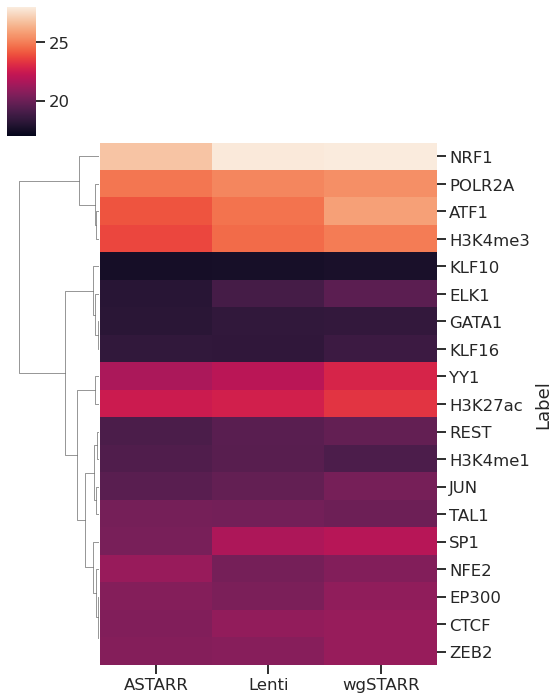

In [19]:
import pandas as pd
import numpy as np
from numpy import trapz
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

ChIP_ASTARRp=[]
ChIP_Lentip=[]
ChIP_wgSTARRp=[]

label=hm_ASTARRd.__dict__['parameters']['sample_labels'][0:19]

for ii in range(len(label)):
    
    signal_ASTARRp=np.nansum(hm_ASTARRp.matrix.matrix[:555, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_ASTARRp.matrix.matrix[555:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_ASTARRp.append(signal_ASTARRp)
    
    signal_Lentip=np.nansum(hm_lentiMPRAp.matrix.matrix[:1587, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_lentiMPRAp.matrix.matrix[1587:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_Lentip.append(signal_Lentip)
    
    signal_wgSTARRp=np.nansum(hm_wgSTARRp.matrix.matrix[:1684, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_wgSTARRp.matrix.matrix[1684:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_wgSTARRp.append(signal_wgSTARRp)
    
DF_ASTARR = pd.DataFrame(np.column_stack([label, ChIP_ASTARRp]), columns=['Label', 'ASTARR'])
DF_Lenti = pd.DataFrame(np.column_stack([label, ChIP_Lentip]), columns=['Label', 'Lenti'])
DF_wgSTARR = pd.DataFrame(np.column_stack([label, ChIP_wgSTARRp]), columns=['Label', 'wgSTARR'])

DF_ASTARR[['ASTARR']]=DF_ASTARR[['ASTARR']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_Lenti[['Lenti']]=DF_Lenti[['Lenti']].apply(pd.to_numeric, errors='coerce', axis=1) 
DF_wgSTARR[['wgSTARR']]=DF_wgSTARR[['wgSTARR']].apply(pd.to_numeric, errors='coerce', axis=1)

DF = DF_ASTARR.merge(DF_Lenti, on='Label', how='inner').merge(DF_wgSTARR, on='Label', how='inner')

DF = DF.set_index('Label')
DF = DF.transform(lambda x: np.log2(x))
sns.clustermap(DF.loc[:, ['ASTARR','Lenti','wgSTARR']],
               method='ward',
               figsize=[8,10],
               vmin=17,
               vmax=28,
               col_cluster= False)



### Distal with ChIPseq Signal

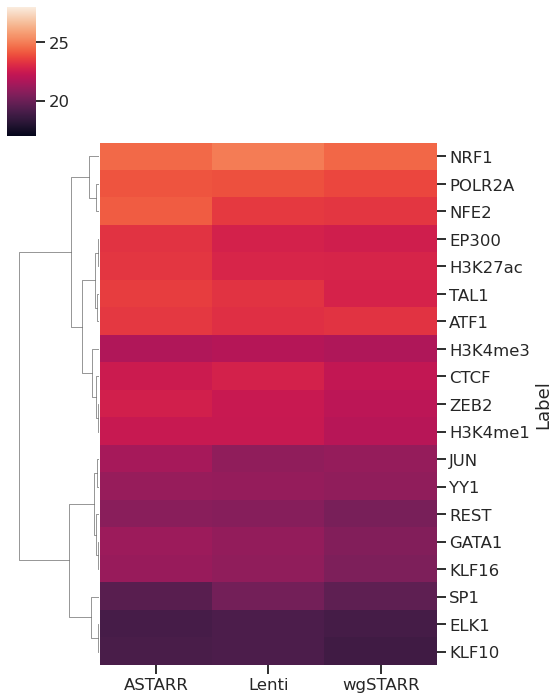

In [21]:
import pandas as pd
import numpy as np
from numpy import trapz
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

ChIP_ASTARRd=[]
ChIP_Lentid=[]
ChIP_wgSTARRd=[]

label=hm_ASTARRd.__dict__['parameters']['sample_labels'][0:19]

for ii in range(len(label)):

    signal_ASTARRd=np.nansum(hm_ASTARRd.matrix.matrix[:2282, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_ASTARRd.matrix.matrix[2282:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_ASTARRd.append(signal_ASTARRd) 
    
    signal_Lentid=np.nansum(hm_lentiMPRAd.matrix.matrix[:3408, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_lentiMPRAd.matrix.matrix[3408:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_Lentid.append(signal_Lentid)
    
    signal_wgSTARRd=np.nansum(hm_wgSTARRd.matrix.matrix[:3316, ((ii)*400)+150:((ii+1)*400)-150])+np.nansum(hm_wgSTARRd.matrix.matrix[3316:, ((ii)*400)+150:((ii+1)*400)-150])
    ChIP_wgSTARRd.append(signal_wgSTARRd)
    
DF_ASTARR = pd.DataFrame(np.column_stack([label,ChIP_ASTARRd]), columns=['Label', 'ASTARR'])
DF_Lenti = pd.DataFrame(np.column_stack([label,ChIP_Lentid]), columns=['Label', 'Lenti'])
DF_wgSTARR = pd.DataFrame(np.column_stack([label,ChIP_wgSTARRd]), columns=['Label', 'wgSTARR'])

DF_ASTARR[['ASTARR']]=DF_ASTARR[['ASTARR']].apply(pd.to_numeric, errors='coerce', axis=1)
DF_Lenti[['Lenti']]=DF_Lenti[['Lenti']].apply(pd.to_numeric, errors='coerce', axis=1) 
DF_wgSTARR[['wgSTARR']]=DF_wgSTARR[['wgSTARR']].apply(pd.to_numeric, errors='coerce', axis=1)

DF = DF_ASTARR.merge(DF_Lenti, on='Label', how='inner').merge(DF_wgSTARR, on='Label', how='inner')

DF = DF.set_index('Label')
DF = DF.transform(lambda x: np.log2(x))
sns.clustermap(DF.loc[:, ['ASTARR','Lenti','wgSTARR']],
               method='ward',
               figsize=[8,10],
               vmin=17,
               vmax=28,
               col_cluster= False)


